In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Mounted at /content/drive/


In [ ]:
image_dir = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k/bdd100k/images/100k/daytime'
mask_dir = '/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k_ins_seg/bdd100k/labels/ins_seg/colormaps/daytime'

In [ ]:
# import os
# import cv2
# import numpy as np

# def load_and_clean_data(image_dir, mask_dir, target_size=(256, 256)):
#     image_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(image_dir))}
#     mask_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(mask_dir))}

#     # Identify unmatched files
#     unmatched_images = set(image_files.keys()) - set(mask_files.keys())
#     unmatched_masks = set(mask_files.keys()) - set(image_files.keys())

#     # Delete unmatched files
#     for unmatched_img in unmatched_images:
#         os.remove(os.path.join(image_dir, image_files[unmatched_img]))
#         print(f"Deleted unmatched image: {image_files[unmatched_img]}")

#     for unmatched_mask in unmatched_masks:
#         os.remove(os.path.join(mask_dir, mask_files[unmatched_mask]))
#         print(f"Deleted unmatched mask: {mask_files[unmatched_mask]}")

#     images = []
#     masks = []
#     count = 0

#     for img_name in image_files.keys() & mask_files.keys():
#         # Read image and mask
#         img_path = os.path.join(image_dir, image_files[img_name])
#         mask_path = os.path.join(mask_dir, mask_files[img_name])

#         img = cv2.imread(img_path)
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#         # Resize images and masks to target size
#         img_resized = cv2.resize(img, target_size)
#         mask_resized = cv2.resize(mask, target_size)

#         # Normalize image to [0, 1] range
#         img_resized = img_resized / 255.0
#         mask_resized = mask_resized[..., np.newaxis] / 255.0  # Add channel dimension

#         images.append(img_resized)
#         masks.append(mask_resized)

#         count += 1
#         if count % 100 == 0:  # Print progress every 100 images
#             print(f"Loaded {count} image-mask pairs.")

#         if count == 1000:  # Optional limit for testing
#             break

#     return np.array(images), np.array(masks)

# images, masks = load_and_clean_data(image_dir, mask_dir)

In [ ]:
images.shape

NameError: name 'images' is not defined

In [ ]:
fig, axs = plt.subplots(1, 2)
idx = np.random.randint(0, len(images))
# Plot the image pairs
axs[0].imshow(images[idx])
axs[0].set_title('Image 1')
axs[1].imshow(masks[idx].squeeze())
axs[1].set_title('Image 2')

plt.show()

In [ ]:
## final working code for grey scale image
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(f"Total image files: {len(images)}, Total mask files: {len(masks)}")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")
print(f"Training mask shape: {y_train.shape}, Validation mask shape: {y_val.shape}")

# Convert data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to define the improved U-Net
def improved_unet(input_size=(256, 256, 3)):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')

    # Encoder (Pre-trained Backbone)
    layer_names = [
        'block_1_expand_relu',   # 128x128
        'block_3_expand_relu',   # 64x64
        'block_6_expand_relu',   # 32x32
        'block_13_expand_relu',  # 16x16
        'block_16_project',      # 8x8
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    encoder = tf.keras.Model(inputs=base_model.input, outputs=layers)

    inputs = tf.keras.layers.Input(shape=input_size)
    encoder_outputs = encoder(inputs)

    # Decoder (Upsampling)
    x = encoder_outputs[-1]
    for i in range(5, 0, -1):
        x = tf.keras.layers.Conv2DTranspose(
            filters=256 // (2**(5-i)),
            kernel_size=(3, 3),
            strides=2,
            padding="same"
        )(x)
        if i > 1:
            x = tf.keras.layers.concatenate([x, encoder_outputs[i-2]])
        x = tf.keras.layers.Conv2D(256 // (2**(5-i)), (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(256 // (2**(5-i)), (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # Final layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Loss function: Binary Crossentropy + Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Training setup
def get_model(input_size=(256, 256, 3)):
    model = improved_unet(input_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),
                  metrics=['accuracy'])
    return model

# Data augmentation
def augment_data(images, masks, batch_size=32):
     # Create ImageDataGenerator for data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create a flow for images and masks, combining them with zip
    image_flow = datagen.flow(images, batch_size=batch_size, seed=42)
    mask_flow = datagen.flow(masks, batch_size=batch_size, seed=42)

    # Zip the image and mask flows together
    return image_flow, mask_flow, batch_size

# Visualization
def visualize_results(images, masks, predictions, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load and preprocess your data
def load_and_preprocess_image(img_path, mask_path, target_size=(256, 256)):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    img_normalized = img_resized.astype(np.float32) / 255.0
    mask_normalized = mask_resized.astype(np.float32) / 255.0
    mask_normalized = mask_normalized[..., np.newaxis]

    return img_normalized, mask_normalized

def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256), max_images=1000):
    image_files = {os.path.splitext(f)[0]: f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}
    mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}

    common_keys = sorted(set(image_files.keys()) & set(mask_files.keys()))[:max_images]

    images = []
    masks = []

    with ThreadPoolExecutor() as executor:
        future_to_key = {executor.submit(load_and_preprocess_image,
                                         os.path.join(image_dir, image_files[img_name]),
                                         os.path.join(mask_dir, mask_files[img_name]),
                                         target_size): img_name for img_name in common_keys}

        for future in as_completed(future_to_key):
            img, mask = future.result()
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)


In [ ]:
# Training the model
image_folder = image_dir
mask_folder = mask_dir

images, masks = load_and_preprocess_data(image_folder, mask_folder)

# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
# ]

In [ ]:
model = get_model()

<ipython-input-3-195ced5e8a93>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 128, 128, 96), │      1,841,984 │ input_layer_1[0][0]    │
│                           │ (None, 64, 64, 144),   │                │                        │
│                           │ (None, 32, 32, 192),   │                │                        │
│                           │ (None, 16, 16, 576),   │                │                        │
│                           │ (None, 8, 8, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 256)    │        737,536 │ functional[0][4]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 832)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 256)    │      1,917,184 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 256)    │          1,024 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 256)    │          1,024 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 128)    │        295,040 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 320)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │        368,768 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 6,206,625 (23.68 MB)

 Trainable params: 6,173,729 (23.55 MB)

 Non-trainable params: 32,896 (128.50 KB)

In [ ]:
# images_train, images_val, masks_train, masks_val = train_test_split(
#     images, masks, test_size=0.2, random_state=42
# )

# images, masks, batch_size = augment_data(images_train, masks_train)

# images = list(images.as_numpy_iterator())  # Convert images to list of NumPy arrays
# masks = list(masks.as_numpy_iterator())

# # Convert the lists to NumPy arrays
# images = np.array(images)
# masks = np.array(masks)

In [ ]:
type(images)

numpy.ndarray

In [ ]:
history = model.fit(x=images, y=masks, steps_per_epoch=50, epochs=50)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 216ms/step - accuracy: 0.5493 - loss: 1.7221
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.7287 - loss: 1.4983
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.8161 - loss: 1.4413
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.8349 - loss: 1.4049
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.8448 - loss: 1.3774
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.8494 - loss: 1.3594
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.8568 - loss: 1.3120
Epoch 14/50
50/

In [ ]:
sample_image, sample_mask = images, masks
sample_image_input = sample_image.reshape(-1, 256, 256, 3)  # Add batch dimension
# sample_image_input = np.expand_dims(sample_image, axis=0)  # Add batch dimension
predicted_mask = model.predict(sample_image_input)

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 395ms/step


In [ ]:
def plot_images_masks_predictions(images, masks, predictions, num_samples=10):
    """
    Plots a few samples of images, corresponding masks, and predicted masks.

    Args:
        images (numpy array): Array of images.
        masks (numpy array): Array of ground truth masks.
        predictions (numpy array): Array of predicted masks.
        num_samples (int): Number of samples to display.
    """
    # Ensure we don't exceed the available number of images
    num_samples = min(num_samples, len(images), len(masks), len(predictions))

    plt.figure(figsize=(10, num_samples * 5))

    for i in range(num_samples):
        # Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Assuming `images`, `masks`, and `predicted_masks` are numpy arrays
plot_images_masks_predictions(images, masks, predicted_mask)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.save("/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/MobileNetV3_unet.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                   loss=lambda y_true, y_pred: tf.keras.losses.BinaryCrossentropy()(y_true, y_pred) + dice_loss(y_true, y_pred),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [ ]:
# history = model.fit(
#     train_gen,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=val_gen,
#     validation_steps=len(images_val) // batch_size # Use batch_size directly
# )

In [ ]:
# Load the best model and evaluate
model.load_weights("best_model.h5")
predictions = model.predict(images[:5])

# Visualize results
visualize_results(images[:5], masks[:5], predictions)

In [ ]:
# U-Net Model architecture
def unet_model(input_size=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_size)

    # Encoder (downsampling)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder (upsampling)
    up5 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    merge5 = tf.keras.layers.concatenate([conv3, up5], axis=3)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = tf.keras.layers.concatenate([conv2, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv1, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = tf.keras.models.Model(inputs, outputs)
    return model


In [ ]:
# Initialize U-Net model
model = unet_model(input_size=(256, 256, 3))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Check the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 64, 64, 256)    │        524,544 │ conv2d_26[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 64, 64, 512)    │              0 │ conv2d_24[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_transpose_4[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 256)    │      1,179,904 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5   

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 728ms/step - accuracy: 0.8875 - loss: 0.3217 - val_accuracy: 0.8902 - val_loss: 0.2034
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 682ms/step - accuracy: 0.8898 - loss: 0.2003 - val_accuracy: 0.8902 - val_loss: 0.1908
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 672ms/step - accuracy: 0.8898 - loss: 0.1928 - val_accuracy: 0.8902 - val_loss: 0.1917
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - accuracy: 0.8898 - loss: 0.1906 - val_accuracy: 0.8902 - val_loss: 0.1839
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.8898 - loss: 0.1872 - val_accuracy: 0.8902 - val_loss: 0.1829
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 683ms/step - accuracy: 0.8898 - loss: 0.1848 - val_accuracy: 0.8902 - val_loss: 0.1801
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - accuracy: 0.8898 - loss: 0.1822 - val_accuracy: 0.8902 - val_loss: 0.1775
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 676ms/step - accuracy: 0.8898 - loss: 0.1781 - val_accu

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

# Visualize a sample prediction
sample_image, sample_mask = X_val[0], y_val[0]
sample_image_input = np.expand_dims(sample_image, axis=0)  # Add batch dimension
predicted_mask = model.predict(sample_image_input)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.8916 - loss: 0.1853
Validation loss: 0.19634492695331573, Validation accuracy: 0.8898849487304688
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


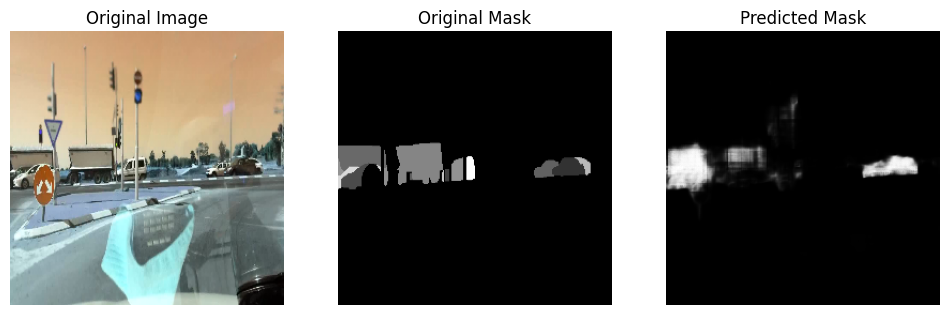

In [ ]:
# Plot the input image and the predicted mask
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

# Original mask
plt.subplot(1, 3, 2)
plt.title("Original Mask")
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/jaskirat_unet.keras")

# Testing.......

In [ ]:
# new_model = tf.keras.models.load_model("/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/MobileNetV3_unet.keras")

# Load the model with safe_mode=False
new_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/MobileNetV3_unet.keras",
    safe_mode=False  # Allow lambda loading
)

In [ ]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 128, 128, 96), │      1,841,984 │ input_layer_1[0][0]    │
│                           │ (None, 64, 64, 144),   │                │                        │
│                           │ (None, 32, 32, 192),   │                │                        │
│                           │ (None, 16, 16, 576),   │                │                        │
│                           │ (None, 8, 8, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 256)    │        737,536 │ functional[0][4]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 832)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 256)    │      1,917,184 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 256)    │          1,024 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 256)    │          1,024 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 128)    │        295,040 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 320)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 128)    │        368,768 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 18,554,085 (70.78 MB)

 Trainable params: 6,173,729 (23.55 MB)

 Non-trainable params: 32,896 (128.50 KB)

 Optimizer params: 12,347,460 (47.10 MB)

In [ ]:
image_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k/bdd100k/images/100k/night"
mask_folder = "/content/drive/MyDrive/ECE 579: Intelligent Systems Project/Code/Datasets/BDD100k/bdd100k_ins_seg/bdd100k/labels/ins_seg/colormaps/night"

In [ ]:
import os
import cv2
import numpy as np

def load_and_clean_data(image_dir, mask_dir, target_size=(256, 256)):
    image_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(image_dir))}
    mask_files = {os.path.splitext(f)[0]: f for f in sorted(os.listdir(mask_dir))}

    # Identify unmatched files
    unmatched_images = set(image_files.keys()) - set(mask_files.keys())
    unmatched_masks = set(mask_files.keys()) - set(image_files.keys())

    # Delete unmatched files
    for unmatched_img in unmatched_images:
        os.remove(os.path.join(image_dir, image_files[unmatched_img]))
        print(f"Deleted unmatched image: {image_files[unmatched_img]}")

    for unmatched_mask in unmatched_masks:
        os.remove(os.path.join(mask_dir, mask_files[unmatched_mask]))
        print(f"Deleted unmatched mask: {mask_files[unmatched_mask]}")

    images = []
    masks = []
    count = 0

    for img_name in image_files.keys() & mask_files.keys():
        # Read image and mask
        img_path = os.path.join(image_dir, image_files[img_name])
        mask_path = os.path.join(mask_dir, mask_files[img_name])

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize images and masks to target size
        img_resized = cv2.resize(img, target_size)
        mask_resized = cv2.resize(mask, target_size)

        # Normalize image to [0, 1] range
        img_resized = img_resized / 255.0
        mask_resized = mask_resized[..., np.newaxis] / 255.0  # Add channel dimension

        images.append(img_resized)
        masks.append(mask_resized)

        count += 1
        if count % 100 == 0:  # Print progress every 100 images
            print(f"Loaded {count} image-mask pairs.")

        if count == 1000:  # Optional limit for testing
            break

    return np.array(images), np.array(masks)

images, masks = load_and_clean_data(image_folder, mask_folder)

Loaded 100 image-mask pairs.


In [ ]:
images.shape

(115, 256, 256, 3)

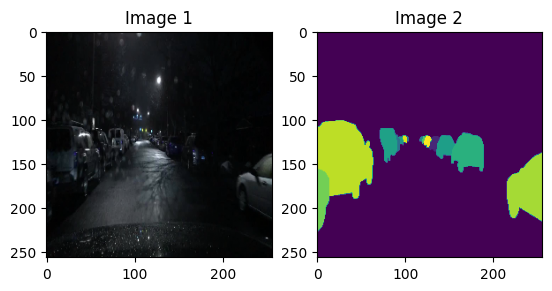

In [ ]:
fig, axs = plt.subplots(1, 2)
idx = np.random.randint(0, len(images))
# Plot the image pairs
axs[0].imshow(images[idx])
axs[0].set_title('Image 1')
axs[1].imshow(masks[idx].squeeze())
axs[1].set_title('Image 2')

plt.show()

In [ ]:
# # Evaluate the model on the validation set
# test_loss, test_accuracy = new_model.evaluate(images)
# print(f"Validation loss: {test_loss}, Validation accuracy: {test_accuracy}")

# Visualize a sample prediction
sample_image, sample_mask = images, masks
sample_image_input = sample_image.reshape(-1, 256, 256, 3)  # Add batch dimension
# sample_image_input = np.expand_dims(sample_image, axis=0)  # Add batch dimension
predicted_mask = new_model.predict(sample_image_input)

4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


In [ ]:
def plot_images_masks_predictions(images, masks, predictions, num_samples=5):
    """
    Plots a few samples of images, corresponding masks, and predicted masks.

    Args:
        images (numpy array): Array of images.
        masks (numpy array): Array of ground truth masks.
        predictions (numpy array): Array of predicted masks.
        num_samples (int): Number of samples to display.
    """
    # Ensure we don't exceed the available number of images
    num_samples = min(num_samples, len(images), len(masks), len(predictions))

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Assuming `images`, `masks`, and `predicted_masks` are numpy arrays
plot_images_masks_predictions(images, masks, predicted_mask)

Output hidden; open in https://colab.research.google.com to view.